# Sentence Correction using Recurrent Neural Network

1.Social media text messages contains short form of english text and it leads to machine learning models to predict the wrong english sentences.

2.This case study helps in converting the social media text message into proper english text messages

#### SOURCE Data Description

1. Source Data Link http://www.comp.nus.edu.sg/~nlp/sw/sm_norm_mt.tar.gz

2. SourceFile Size:413KB

3. Description of the SourceData.This source file contains three types of data
        
        1.Social Media Text messages
        
        2.Chinese messages
        
        3.Original English Text
        
        
4. Number of rows present in source data: 2000        
        

### Machine Learning Probelm

1. In this case study i am implementing research paper on sentence correction using RNN's
      Link:https://cs224d.stanford.edu/reports/Lewis.pdf
      
2. Using Encoder and Decoder Sequence to Sequenc network with LSTM which are types of RNN's 

3. Loss function : categorical_crossentropy
      

In [6]:
%tensorflow_version 2.x
import tensorflow as tf
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
    raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


In [7]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [8]:
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import pandas as pd
import re
import tensorflow as tf
from tensorflow.keras.layers import Embedding, LSTM, Dense,Input
from tensorflow.keras.models import Model,load_model
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import numpy as np

### Extracting the Data

In [ ]:
file = open("/content/drive/MyDrive/CaseStudy2/en2cn-2k.en2nen2cn",'r',encoding = 'utf-8')

In [ ]:
File_Lines=[]
with open("/content/drive/MyDrive/CaseStudy2/en2cn-2k.en2nen2cn") as fp:
    Lines = fp.readlines()
    File_Lines=Lines

In [ ]:
# In this piece of code,looping through the source file and extracting the normalized text and english text
Original_English_Text=[]
Normalized_Text=[]
Chinese_Text=[]
Normalized_count=0
English_count=1
Chinese_count=2
for i in range(len(File_Lines)):
    if (Normalized_count==len(File_Lines)):
        break
    else:  
        Normalized_Text.append(File_Lines[Normalized_count])
        Original_English_Text.append(File_Lines[English_count])
        Chinese_Text.append(File_Lines[Chinese_count])
        Normalized_count=Normalized_count+3
        English_count=English_count+3
        Chinese_count=Chinese_count+3

In [ ]:
print(len(Original_English_Text))
print(len(Normalized_Text))
print(len(Chinese_Text))

2000
2000
2000


In [ ]:
print(Original_English_Text[5])
print(Normalized_Text[5])

Haha. Okay. Are you going to mail her? Or do you want me to reply?

Haha... Okay... You going to mail her? Or you want me to reply...



In [ ]:
Data={"NormalizedText":Normalized_Text,"Original_English_Text":Original_English_Text}

In [ ]:
import pandas as pd
SourceData=pd.DataFrame(Data)


In [ ]:
print(SourceData.head(5))

                                      NormalizedText                              Original_English_Text
0                  U wan me to "chop" seat 4 u nt?\n   Do you want me to reserve seat for you or not?\n
1  Yup. U reaching. We order some durian pastry a...  Yeap. You reaching? We ordered some Durian pas...
2  They become more ex oredi... Mine is like 25.....  They become more expensive already. Mine is li...
3                          I'm thai. what do u do?\n                        I'm Thai. What do you do?\n
4  Hi! How did your week go? Haven heard from you...  Hi! How did your week go? Haven't heard from y...


In [ ]:
pd.to_pickle(SourceData, "/content/drive/MyDrive/CaseStudy2/SourceData.pkl")

**Importing Source Data**

In [ ]:
# Reading the Source File

import pandas as pd
Data=pd.read_pickle(r"/content/drive/MyDrive/CaseStudy2/SourceData.pkl")

In [ ]:
Data.head(5)

,NormalizedText,Original_English_Text
0,"U wan me to ""chop"" seat 4 u nt?\n",Do you want me to reserve seat for you or not?\n
1,Yup. U reaching. We order some durian pastry a...,Yeap. You reaching? We ordered some Durian pas...
2,They become more ex oredi... Mine is like 25.....,They become more expensive already. Mine is li...
3,I'm thai. what do u do?\n,I'm Thai. What do you do?\n
4,Hi! How did your week go? Haven heard from you...,Hi! How did your week go? Haven't heard from y...


In [ ]:
#Maximum length in words
Max_Length_Normalized_Text = Data['NormalizedText'].str.split().str.len().max()
print("The maximum length in words for NormalizedText before preprocessing: " +  str(Max_Length_Normalized_Text)) 

Max_Length_Original_English_Text = Data['Original_English_Text'].str.split().str.len().max()
print("The maximum length in words for Original English Text before preprocessing: " +  str(Max_Length_Original_English_Text)) 

The maximum length in words for NormalizedText before preprocessing: 49
The maximum length in words for Original English Text before preprocessing: 59


In [ ]:
#Minimum length in words

Min_Length_Normalized_Text = Data['NormalizedText'].str.split().str.len().min()
print("The minimum length in words for NormalizedText before preprocessing: " +  str(Min_Length_Normalized_Text)) 

Min_Length_Original_English_Text = Data['Original_English_Text'].str.split().str.len().min()
print("The minimum length in words for Original English Text before preprocessing: " +  str(Min_Length_Original_English_Text)) 


The minimum length in words for NormalizedText before preprocessing: 1
The minimum length in words for Original English Text before preprocessing: 1


**Data Augmentation using nlpaug Library**

In [9]:
pip install nlpaug

In [10]:
from nlpaug.util.file.download import DownloadUtil
DownloadUtil.download_fasttext(model_name='wiki-news-300d-1M', dest_dir='.')

In [ ]:
Original_English_Text_Aug=list(Data.Original_English_Text.values)
import nlpaug.augmenter.char as nac
import nlpaug.augmenter.word as naw
Normalized_Text_Aug1=[]
Normalized_Text_Aug2=[]
#aug = naw.SpellingAug()
aug = naw.WordEmbsAug(
    model_type='fasttext', model_path='/content/wiki-news-300d-1M.vec',
    action="insert")
aug_syn = naw.SynonymAug(aug_src='wordnet')
#aug_ocr = nac.OcrAug()
for text in Original_English_Text_Aug:
  augmented_text = aug.augment(text)
  Normalized_Text_Aug1.append(augmented_text)
  augmented_syn = aug_syn.augment(text)
  Normalized_Text_Aug2.append(augmented_syn)

In [ ]:
FastText_Augmented_Data=pd.DataFrame(list(zip(Normalized_Text_Aug1,Original_English_Text_Aug)),columns=['NormalizedText','Original_English_Text'])
Syn_Augmented_Data=pd.DataFrame(list(zip(Normalized_Text_Aug2,Original_English_Text_Aug)),columns=['NormalizedText','Original_English_Text'])

In [ ]:
from sklearn.utils import shuffle
DataFramesList=[Data,FastText_Augmented_Data,Syn_Augmented_Data]
Data=pd.concat(DataFramesList)
Data = shuffle(Data)
pd.to_pickle(Data, "/content/drive/MyDrive/CaseStudy2/AugmentedData.pkl")
print(len(Data))

6000


In [11]:
Data=Data=pd.read_pickle(r"/content/drive/MyDrive/CaseStudy2/AugmentedData.pkl")

## Preprocessing the Data

In [12]:
import re
def decontractions(phrase):
    """decontracted takes text and convert contractions into natural form.
     ref: https://stackoverflow.com/questions/19790188/expanding-english-language-contractions-in-python/47091490#47091490"""
    # specific
    phrase = re.sub(r"won\'t", "will not", phrase)
    phrase = re.sub(r"can\'t", "can not", phrase)
    phrase = re.sub(r"won\’t", "will not", phrase)
    phrase = re.sub(r"can\’t", "can not", phrase)

    # general
    phrase = re.sub(r"n\'t", " not", phrase)
    phrase = re.sub(r"\'re", " are", phrase)
    phrase = re.sub(r"\'s", " is", phrase)
    phrase = re.sub(r"\'d", " would", phrase)
    phrase = re.sub(r"\'ll", " will", phrase)
    phrase = re.sub(r"\'t", " not", phrase)
    phrase = re.sub(r"\'ve", " have", phrase)
    phrase = re.sub(r"\'m", " am", phrase)

    phrase = re.sub(r"n\’t", " not", phrase)
    phrase = re.sub(r"\’re", " are", phrase)
    phrase = re.sub(r"\’s", " is", phrase)
    phrase = re.sub(r"\’d", " would", phrase)
    phrase = re.sub(r"\’ll", " will", phrase)
    phrase = re.sub(r"\’t", " not", phrase)
    phrase = re.sub(r"\’ve", " have", phrase)
    phrase = re.sub(r"\’m", " am", phrase)

    return phrase

def preprocess(text):
    text = text.lower()
    text = decontractions(text)
    text = re.sub('[$)\?"’.°!;\'€%:,(/]', '', text)
    text = re.sub('[^A-Za-z0-9 ]+', '', text)
    text = re.sub('[0-9]','',text)
    return text


In [13]:
Data['Original_English_Text'] = Data['Original_English_Text'].apply(preprocess)
Data['NormalizedText'] = Data['NormalizedText'].apply(preprocess)

In [14]:
Data.head(5)

,NormalizedText,Original_English_Text
1923,hehe so how are you spending your sunday,hehe so how are you spending your sunday
410,pic ok kre i m treadle at city link already,ok i am at city link already
1452,joey be you from india,joey are you from india
691,watch jz married leihh,watch just married haha
464,oh tomorrow ve got driving object lesson can...,oh tomorrow i have got driving lesson can not ...


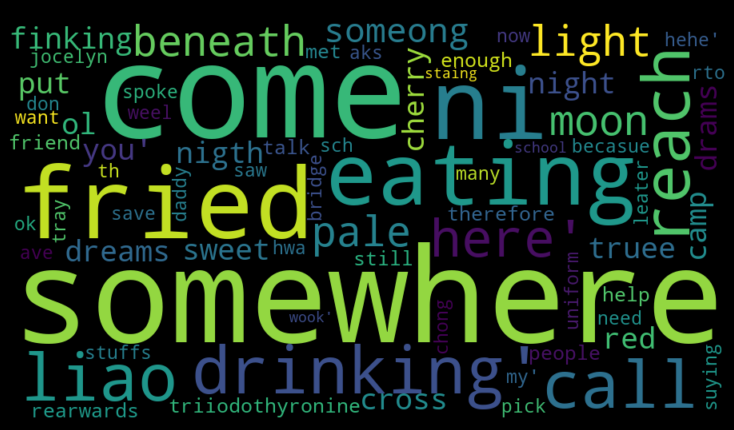

In [ ]:
#Word cloud on NormalizedTextMessages
from wordcloud import WordCloud, STOPWORDS
import matplotlib.pyplot as plt
text = Data.NormalizedText.values
wordcloud = WordCloud(
    width = 900,
    height = 500,
    background_color = 'black',
    stopwords = STOPWORDS).generate(str(text))
fig = plt.figure(
    figsize = (10, 10),
    facecolor = 'k',
    edgecolor = 'k')
plt.imshow(wordcloud, interpolation = 'bilinear')
plt.axis('off')
plt.tight_layout(pad=0)
plt.title("Normalized Text WordCloud")
plt.show()

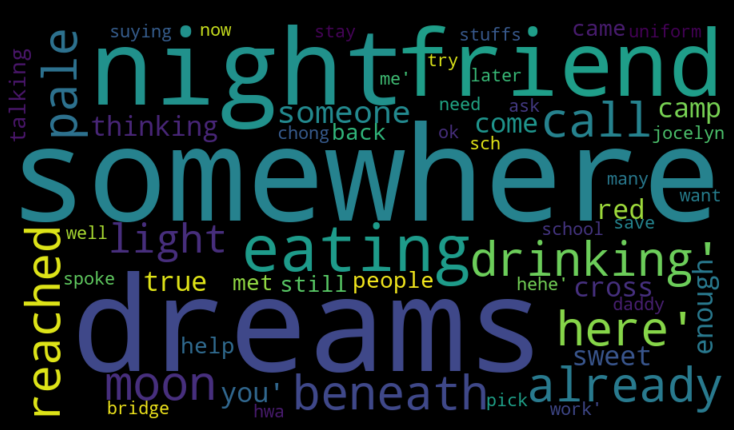

In [ ]:
#WordCloud on Original English Text
text = Data.Original_English_Text.values
wordcloud = WordCloud(
    width = 900,
    height = 500,
    background_color = 'black',
    stopwords = STOPWORDS).generate(str(text))
fig = plt.figure(
    figsize = (10, 10),
    facecolor = 'k',
    edgecolor = 'k')
plt.imshow(wordcloud, interpolation = 'bilinear')
plt.axis('off')
plt.tight_layout(pad=0)
plt.title("Englisg Text WordCloud")
plt.show()

In [15]:
Data['Original_English_Text_inp'] = '<start> ' + Data['Original_English_Text'].astype(str)
Data['Original_English_Text_out'] = Data['Original_English_Text'].astype(str) + ' <end>'

Data.head()

,NormalizedText,Original_English_Text,Original_English_Text_inp,Original_English_Text_out
1923,hehe so how are you spending your sunday,hehe so how are you spending your sunday,<start> hehe so how are you spending your sunday,hehe so how are you spending your sunday <end>
410,pic ok kre i m treadle at city link already,ok i am at city link already,<start> ok i am at city link already,ok i am at city link already <end>
1452,joey be you from india,joey are you from india,<start> joey are you from india,joey are you from india <end>
691,watch jz married leihh,watch just married haha,<start> watch just married haha,watch just married haha <end>
464,oh tomorrow ve got driving object lesson can...,oh tomorrow i have got driving lesson can not ...,<start> oh tomorrow i have got driving lesson ...,oh tomorrow i have got driving lesson can not ...


In [16]:
Data = Data.drop(['Original_English_Text'], axis=1)

In [17]:
from sklearn.model_selection import train_test_split
train, test = train_test_split(Data, test_size=0.2) 
train,validation=train_test_split(train, test_size=0.075)
print(len(train))
print(len(test))
print(len(validation))

4440
1200
360


In [18]:
tknizer_english = Tokenizer(filters='!"#$%&()*+,-./:;=?@[\\]^_`{|}~\t\n',char_level=False)
tknizer_english.fit_on_texts(train['Original_English_Text_inp'].values)
tknizer_normal_text = Tokenizer(filters='!"#$%&()*+,-./:;=?@[\\]^_`{|}~\t\n',char_level=False)
tknizer_normal_text.fit_on_texts(train['NormalizedText'].values)

In [19]:
encoder_vcab=tknizer_normal_text.word_index
decoder_vcab=tknizer_english.word_index

In [20]:
vocab_size_eng=len(tknizer_english.word_index.keys())
print(vocab_size_eng)
vocab_size_normal_text=len(tknizer_normal_text.word_index.keys())
print(vocab_size_normal_text)

2833
11905


In [21]:
embeddings_index = dict()
Decoder_embedding_index=dict()
f = open('/content/wiki-news-300d-1M.vec')
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()

Encoder_embedding_matrix = np.zeros((len(encoder_vcab)+1, 300))
for word, i in encoder_vcab.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        Encoder_embedding_matrix[i] = embedding_vector

Decoder_embedding_matrix = np.zeros((len(decoder_vcab)+1, 300))
for word, i in decoder_vcab.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        Decoder_embedding_matrix[i] = embedding_vector       

In [22]:
print(Encoder_embedding_matrix.shape)
print(Decoder_embedding_matrix.shape)

(11906, 300)
(2834, 300)


In [23]:
class Dataset:
    def __init__(self, Data, tknizer_english, tknizer_normal_text, max_len):
        self.encoder_inps = Data['NormalizedText'].values
        self.decoder_inps = Data['Original_English_Text_inp'].values
        self.decoder_outs = Data['Original_English_Text_out'].values
        self.tknizer_eng = tknizer_english
        self.tknizer_nor= tknizer_normal_text
        self.max_len = max_len

    def __getitem__(self, i):
        self.encoder_seq = self.tknizer_nor.texts_to_sequences([self.encoder_inps[i]]) # need to pass list of values
        self.decoder_inp_seq = self.tknizer_eng.texts_to_sequences([self.decoder_inps[i]])
        self.decoder_out_seq = self.tknizer_eng.texts_to_sequences([self.decoder_outs[i]])
        

        self.encoder_seq = pad_sequences(self.encoder_seq, maxlen=self.max_len, dtype='int32', padding='post')
        self.decoder_inp_seq = pad_sequences(self.decoder_inp_seq, maxlen=self.max_len, dtype='int32', padding='post')
        self.decoder_out_seq = pad_sequences(self.decoder_out_seq, maxlen=self.max_len, dtype='int32', padding='post')
        return self.encoder_seq, self.decoder_inp_seq, self.decoder_out_seq

    def __len__(self): # your model.fit_gen requires this function
        return len(self.encoder_inps)

    
class Dataloder(tf.keras.utils.Sequence):    
    def __init__(self, dataset, batch_size=1):
        self.dataset = dataset
        self.batch_size = batch_size
        self.indexes = np.arange(len(self.dataset.encoder_inps))


    def __getitem__(self, i):
        start = i * self.batch_size
        stop = (i + 1) * self.batch_size
        data = []
        for j in range(start, stop):
            data.append(self.dataset[j])

        batch = [np.squeeze(np.stack(samples, axis=1), axis=0) for samples in zip(*data)]
        # we are creating data like ([italian, english_inp], english_out) these are already converted into seq
        return tuple([[batch[0],batch[1]],batch[2]])
        

    def __len__(self):  # your model.fit_gen requires this function
        return len(self.indexes) // self.batch_size

    def on_epoch_end(self):
        self.indexes = np.random.permutation(self.indexes)

In [24]:
train_dataset = Dataset(train, tknizer_english, tknizer_normal_text, 50)
test_dataset  = Dataset(test, tknizer_english, tknizer_normal_text, 50)
Validation_dataset= Dataset(validation, tknizer_english, tknizer_normal_text, 50)

train_dataloader = Dataloder(train_dataset, batch_size=50)
test_dataloader = Dataloder(test_dataset, batch_size=50)
validation_dataloader=Dataloder(Validation_dataset, batch_size=50) 

In [25]:
print(train_dataloader[0][0][0].shape, train_dataloader[0][0][1].shape, train_dataloader[0][1].shape)
print(test_dataloader[0][0][0].shape)

(50, 50) (50, 50) (50, 50)
(50, 50)
